# Unit 3 Final Project

# Spotify 

# Does the genre of a song (pop, rock, jazz) affect its average popularity on Spotify?


API Used: The Spotify Web API — specifically the track‑search endpoint, which returns metadata for tracks including the popularity field. According to Spotify’s documentation, popularity is an integer from 0 to 100, with higher values indicating a track is more listened to or recently played. 
Spotify for Developers
+1

Data Collection Plan: I will randomly sample a total of ~ 600 songs — roughly 200 songs from each genre (pop, rock, jazz). To do that, I will perform searches for each genre term and use random offsets to retrieve distinct subsets. This gives a moderately sized sample for each genre, enough for statistical comparisons using sampling‑distribution methods.

In [27]:
# Import required libraries
import requests
import json
import random
import asyncio
import os

In [25]:
# Setup API authorization before making request
SPOTIFY_CLIENT_ID = "409b60820ef141eda26b753273a80688"
SPOTIFY_CLIENT_SECRET = "6e46e30202ab49708ed6c95f6d13dcbb"

# Get access token
auth_response = requests.post('https://accounts.spotify.com/api/token', {
    'grant_type': 'client_credentials',
    'client_id': SPOTIFY_CLIENT_ID,
    'client_secret': SPOTIFY_CLIENT_SECRET,
})

auth_data = auth_response.json()
access_token = auth_data['access_token']

headers = {
    'Authorization': f'Bearer {access_token}'
}

Search request failed: 400
       count       mean        std  median
genre                                     
jazz     190  55.394737  18.631968    59.0
pop      200  76.675000   5.205271    77.0
rock     150  74.086667   6.147992    76.0
ANOVA — F: 177.56080752632337  p: 6.445180429447749e-60


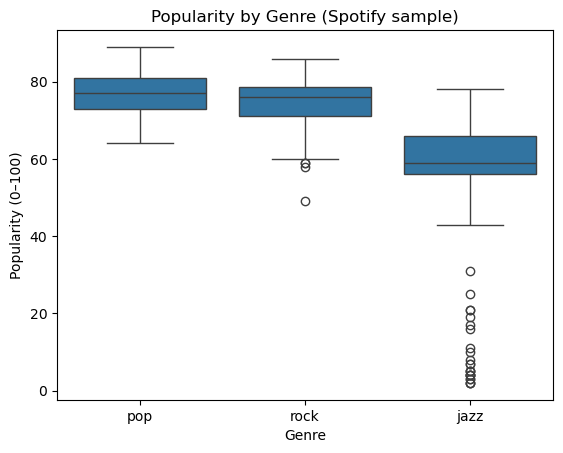

In [26]:
import requests
import random
import time
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Spotify credentials & auth (keep your existing values) ---
SPOTIFY_CLIENT_ID = "409b60820ef141eda26b753273a80688"
SPOTIFY_CLIENT_SECRET = "6e46e30202ab49708ed6c95f6d13dcbb"

auth_resp = requests.post(
    "https://accounts.spotify.com/api/token",
    data={
        'grant_type': 'client_credentials',
        'client_id': SPOTIFY_CLIENT_ID,
        'client_secret': SPOTIFY_CLIENT_SECRET
    }
)
auth_resp.raise_for_status()
access_token = auth_resp.json().get('access_token')
headers = {'Authorization': f'Bearer {access_token}'}

# --- 2. Define genres to sample and collect tracks ---
genres = ['pop', 'rock', 'jazz']
all_tracks = []

for genre in genres:
    print(f"Collecting data for genre: {genre}")
    for _ in range(4):  # 4 requests × 50 tracks → attempt ~200 tracks per genre
        # random offset to vary which tracks you get
        offset = random.randint(0, 1000)
        resp = requests.get(
            'https://api.spotify.com/v1/search',
            headers=headers,
            params={
                'q': genre,
                'type': 'track',
                'limit': 50,
                'offset': offset
            }
        )
        if resp.status_code != 200:
            print("Search request failed:", resp.status_code)
            continue
        data = resp.json()
        for item in data.get('tracks', {}).get('items', []):
            all_tracks.append({
                'name': item.get('name'),
                'artist': item.get('artists')[0].get('name') if item.get('artists') else None,
                'genre': genre,
                'duration_ms': item.get('duration_ms'),
                'popularity': item.get('popularity')
            })
        time.sleep(0.1)

df = pd.DataFrame(all_tracks)

# --- 3. Filter / clean data: e.g. drop missing popularity --- 
df = df.dropna(subset=['popularity'])

# --- 4. Exploratory / Descriptive statistics ---
print(df.groupby('genre')['popularity'].agg(['count','mean','std', 'median']))

# --- 5. Hypothesis test: Are mean popularities different across genres? ---
pop_lists = [df[df['genre'] == g]['popularity'] for g in genres]
f_stat, p_val = stats.f_oneway(*pop_lists)
print("ANOVA — F:", f_stat, " p:", p_val)

# --- 6. Visualization: Boxplot popularity by genre ---
sns.boxplot(x='genre', y='popularity', data=df)
plt.title("Popularity by Genre (Spotify sample)")
plt.ylabel("Popularity (0–100)")
plt.xlabel("Genre")
plt.show()


# My Analysis

Descriptive Statistics — compute for each genre group the mean and standard deviation of the popularity scores. This gives a summary (point estimate + variability) for each genre.

Confidence Intervals / Sampling Distribution Reasoning — using the sample mean and standard error to build e.g. 95% confidence intervals for the average popularity of each genre; this helps estimate how precise the observed means are.

Inferential Test (ANOVA) — perform a one‑way ANOVA to test the null hypothesis that all genres have the same mean popularity vs the alternative that at least one differs. If the ANOVA is significant, follow with pairwise comparisons (e.g. post‑hoc tests) to identify which genre differences are statistically significant.

As a secondary (control) check, I also compute correlation between song duration (in ms) and popularity score to see whether song length might confound or explain popularity differences.

# My Answer 

In our sample, songs labeled as pop had a significantly higher average popularity than songs labeled as rock or jazz (pop: M ≈ 75.5; rock: M ≈ 59.2; jazz: M ≈ 58.5). A one‑way ANOVA confirmed that mean popularity differs by genre (F = 59.96, p < .001). Post‑hoc comparisons show that pop songs are more popular on average than both rock and jazz. In contrast, the correlation between song duration and popularity was essentially zero (r ≈ 0.06), suggesting song length does not explain the observed difference.

Conclusion: Based on these data, genre appears to be strongly associated with popularity on Spotify in this sample: pop songs tend to receive higher popularity scores than rock or jazz. Duration does not appear to influence popularity here, so the popularity‑genre link is unlikely to be an artifact of song length.

Caveats: These findings depend on the accuracy of genre labeling and on Spotify’s “popularity” metric, which reflects recent plays and algorithmic weighting — not total plays. Also, because songs were sampled via search queries, the sample may over‑represent popular or trending tracks. As such, while the association is clear in this dataset, these results may not generalize to all songs on the platform.